In [1]:
import torch
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np

from qiskit.primitives import Estimator
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.utils import algorithm_globals

In [2]:
#########H2_op.numqubit=2

from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

In [3]:
#######Parameterized circuit

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam"), 
          Parameter("theta1"), Parameter("phi1"), Parameter("lam1")]

qr = QuantumRegister(2, name="q")
circ = QuantumCircuit(qr)
circ.u(params[0], params[1], params[2], qr[0])
circ.u(params[3], params[4], params[5], qr[1])
 
print(circ)

       ┌──────────────────┐ 
q_0: ──┤ U(theta,phi,lam) ├─
     ┌─┴──────────────────┴┐
q_1: ┤ U(theta1,phi1,lam1) ├
     └─────────────────────┘


In [4]:
estimator = Estimator()
optimizers = [SLSQP(maxiter=0)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 0
    
    ansatz = circ
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    k = np.random.rand(6)*np.pi*2 #pick random points
    
    vqe = VQE(estimator, ansatz, optimizer, initial_point = k, callback=store_intermediate_result)
    
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    
    print(result)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimizer: SLSQP        {   'aux_operators_evaluated': None,
    'cost_function_evals': 7,
    'eigenvalue': -0.7163696419385484,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f68b0298290>,
    'optimal_parameters': {   Parameter(phi1): 2.6136273007736395,
                              Parameter(theta1): 2.6087773435992525,
                              Parameter(lam1): 5.726426507686947,
                              Parameter(theta): 4.512700538184747,
                              Parameter(lam): 4.485093416916798,
                              Parameter(phi): 0.310536090645369},
    'optimal_point': array([4.48509342, 5.72642651, 0.31053609, 2.6136273 , 4.51270054,
       2.60877734]),
    'optimal_value': -0.7163696419385484,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f68afe6b010>,
    'optimizer_time': 0.010306835174560547}
Optimization complete      


In [5]:
#########################################################################ML part
train_X = torch.rand(5, 6)*np.pi*2

In [6]:
Y = []
for i in range(0,5,1):
    res = VQE(estimator, ansatz, optimizer, initial_point = train_X[i], callback=store_intermediate_result)
    res1 = -res.compute_minimum_eigenvalue(operator=H2_op).eigenvalue
    Y.append(res1)
    #Y += 0.1 * torch.rand_like(Y)


In [7]:
Y= np.array(Y)

train_Y = (Y - Y.mean()) / Y.std()
train_Y = torch.from_numpy(train_Y)
train_Y = train_Y.view(-1,1)
train_Y = train_Y.float()
train_Yvar = torch.full_like(train_Y, 1e-6)

model = FixedNoiseGP(train_X, train_Y, train_Yvar)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/l

In [8]:
from botorch.acquisition.monte_carlo import qExpectedImprovement

ei = qExpectedImprovement(model,best_f=train_Y.max(),maximize=True)

In [9]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(6), torch.ones(6)*np.pi*2])
candidate, acq_value = optimize_acqf(
    ei, bounds=bounds, q=10, num_restarts=10, raw_samples=512,
)

In [10]:
loop = 50
Y_new = Y
# train_X_new = torch.cat([train_X, candidate], dim=0)
train_X_new = train_X

mm = []
ee = []
for ii in range(1,loop):
    train_X_new = torch.cat([train_X_new, candidate], dim=0)
    kk = 0
    
    while kk < 10:
        hh = 5+(ii-1)*10+kk
        res = VQE(estimator, ansatz, optimizer, initial_point = train_X_new[hh], callback=store_intermediate_result)
        new_data = -res.compute_minimum_eigenvalue(operator=H2_op).eigenvalue
        print(new_data)
        ee.append(new_data)
        Y_new = np.append(Y_new, new_data)
    
        kk += 1

    mm.append(np.max(ee))   
    train_Y_new = (Y_new - Y_new.mean()) / Y_new.std()
    train_Y_new_num = torch.from_numpy(train_Y_new)
    train_Y_new_num = train_Y_new_num.view(-1,1)
    train_Y_new_num = train_Y_new_num.float()
    train_Y_new_num_var = torch.full_like(train_Y_new_num, 1e-6)

    model = FixedNoiseGP(train_X_new, train_Y_new_num, train_Y_new_num_var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll);
    
    
    ei = qExpectedImprovement(model,best_f=train_Y.max(),maximize=True)
    
    
    bounds = torch.stack([torch.zeros(6), torch.ones(6)*np.pi*2])
    candidate, acq_value = optimize_acqf(
    ei, bounds=bounds, q=10, num_restarts=20, raw_samples=512)
     
    print(candidate)
    

1.2807343668562086
1.0795726539705748
1.09786739942928
0.5009698796028397
0.3985371185553339
1.683653052003498
0.9434127863089646
1.534240326796388
1.0208928956279368
1.1608818304737336


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/l

tensor([[3.4832, 2.1985, 3.6147, 2.1476, 1.6558, 5.6245],
        [4.0177, 2.9784, 3.9342, 5.6539, 4.1703, 1.3582],
        [4.7147, 3.4468, 3.0406, 4.8058, 2.1863, 3.8818],
        [2.7656, 3.5462, 2.0629, 1.5392, 4.0956, 0.6614],
        [1.7486, 4.9643, 1.6664, 1.8490, 5.7409, 2.6858],
        [0.2333, 0.8753, 1.0503, 1.5005, 1.0286, 0.9368],
        [6.2584, 3.9785, 5.2794, 0.9715, 2.1494, 2.8465],
        [4.2421, 2.7378, 4.4487, 3.9746, 0.0967, 4.3141],
        [1.4959, 5.5164, 6.1820, 1.1743, 5.2827, 5.3583],
        [4.2181, 1.5888, 0.5714, 0.8825, 1.1664, 0.9942]])
1.4536550908583548
1.2544222897667061
0.9839001656703144
1.5900723194913378
0.34663030494341146
1.0818403096801446
0.8817877305294494
0.5004418390371466
1.0339695249081164
1.0406529069272075
tensor([[0.9814, 2.0007, 2.1240, 1.5300, 6.0801, 4.0920],
        [3.6835, 5.0184, 4.9408, 2.8071, 6.0640, 1.7193],
        [2.0170, 2.0640, 1.8144, 2.3141, 5.1273, 4.4861],
        [2.8413, 5.4967, 5.5677, 2.9030, 5.6947, 4.766

/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/l

tensor([[1.7881, 1.7827, 2.9546, 0.9534, 0.1591, 2.9248],
        [5.6280, 0.9705, 5.3731, 0.7973, 4.6828, 1.3979],
        [3.3946, 1.5341, 2.6282, 0.2394, 2.6527, 1.3236],
        [4.8872, 4.9900, 4.9191, 5.9011, 5.1644, 6.1470],
        [2.1699, 4.6829, 3.8321, 4.7371, 2.6231, 0.3134],
        [1.7568, 0.4614, 2.7028, 5.9619, 0.4484, 1.6072],
        [1.1265, 0.3397, 4.1735, 0.5004, 1.0917, 0.4167],
        [5.4219, 5.3926, 2.3100, 0.5907, 2.4840, 1.9708],
        [4.5054, 1.2885, 5.0194, 0.9576, 1.2730, 1.0009],
        [5.0473, 1.7279, 1.5598, 2.7651, 1.5220, 5.5335]])
0.2634751797372691
1.2089454241300666
1.5683442441764905
1.2734846277065253
1.7677597243426424
0.7462708957788744
1.2668305874738117
1.2728195569966716
1.1267849962732033
1.3233679538748095


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/l

tensor([[0.3549, 5.6926, 6.1958, 5.0695, 3.2648, 0.0564],
        [2.1695, 4.6827, 3.8321, 4.7373, 2.6224, 0.3130],
        [5.5029, 2.0145, 2.2362, 1.1827, 0.8243, 1.1660],
        [5.9682, 5.2438, 5.2800, 4.1497, 2.5972, 0.8775],
        [5.9552, 6.1740, 5.2322, 2.3635, 3.4844, 5.6707],
        [3.6265, 1.3240, 0.1521, 3.5672, 1.4424, 1.4870],
        [6.2774, 1.7298, 3.7041, 4.4934, 5.3834, 0.0638],
        [4.3060, 2.2081, 3.8340, 4.3529, 2.6668, 4.5456],
        [3.0596, 0.0710, 4.1581, 6.2439, 3.1851, 0.9780],
        [2.4874, 2.2082, 4.4653, 3.7362, 3.3755, 0.4823]])
1.8338572522132306
1.767693649920527
0.9704018091295946
1.661584701609874
1.756439564649034
1.1958276534782573
1.2107395895181723
1.363976891253324
1.6625274556999605
1.7862454390405202


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.0481, 1.5235, 1.1854, 6.1739, 4.9964, 0.2595],
        [2.1819, 4.6424, 3.9523, 4.7184, 2.6228, 0.3283],
        [0.5381, 5.5220, 4.6914, 5.7851, 0.1569, 1.7797],
        [2.8372, 4.7363, 4.5968, 4.0918, 3.8965, 4.3610],
        [0.3822, 4.9565, 2.2235, 4.4224, 1.5713, 5.1891],
        [3.6012, 3.9491, 3.6094, 0.9127, 2.6367, 0.2581],
        [0.0634, 1.4138, 4.3743, 4.7512, 0.0488, 5.0013],
        [0.6082, 4.1445, 2.4251, 4.8062, 0.5800, 4.4565],
        [2.9535, 5.0287, 3.4819, 3.4000, 5.0966, 4.8230],
        [6.2368, 0.6473, 4.3610, 1.2638, 1.2219, 1.2421]])
1.3451803646774056
1.7654770998905338
0.5750106883325208
1.2002360850094946
1.2630616537844062
1.7880587537318273
0.7713747626889954
0.6096440867857286
0.7956482755122428
1.0627825425815365


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.6249e+00, 3.9131e+00, 7.2897e-01, 7.1482e-01, 2.2026e+00, 1.5892e+00],
        [5.3627e-01, 4.9140e+00, 1.2612e+00, 4.5947e+00, 1.8388e+00, 5.9798e-01],
        [2.7630e+00, 2.1286e+00, 3.8514e+00, 2.8317e+00, 1.2304e+00, 1.2452e-01],
        [5.0699e+00, 1.9885e+00, 5.4004e+00, 1.8502e+00, 1.3662e+00, 1.4830e+00],
        [3.2134e+00, 2.5521e+00, 2.7159e+00, 2.7584e+00, 4.2420e+00, 2.9329e-01],
        [3.6766e+00, 2.7535e+00, 4.5630e+00, 3.3564e+00, 4.1635e+00, 2.0355e+00],
        [4.0516e+00, 1.7663e+00, 4.3033e+00, 6.0448e+00, 5.5443e+00, 1.8306e+00],
        [1.5807e+00, 4.1728e+00, 4.9984e+00, 2.1322e+00, 3.9533e+00, 1.2594e+00],
        [2.1754e+00, 4.6636e+00, 3.8884e+00, 4.7283e+00, 2.6229e+00, 3.1966e-01],
        [2.9993e+00, 3.8763e-03, 3.8767e+00, 6.1588e+00, 3.3913e+00, 9.0098e-01]])
1.197971288957358
1.4876983008996394
1.3028054701967764
1.0375224605404227
1.6481816683475916
1.1043336749913193
0.6083271460765909
1.4270324681972186
1.7667769911572713
1.6524476

/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[3.6139, 5.1407, 2.2576, 0.2234, 4.6545, 3.2880],
        [3.7634, 3.8363, 2.8300, 5.8385, 2.3819, 4.1774],
        [4.7057, 2.5887, 1.3610, 3.8268, 4.5369, 5.1549],
        [4.0613, 6.2199, 4.7286, 5.5193, 2.9540, 1.8924],
        [6.1193, 1.7287, 2.6909, 1.4170, 3.0448, 5.6689],
        [4.4609, 1.6403, 3.9988, 3.1657, 1.4084, 3.7073],
        [0.8915, 1.5892, 1.6843, 5.0784, 3.8306, 2.2984],
        [0.3543, 5.6928, 6.1977, 5.0687, 3.2654, 0.0560],
        [3.5803, 1.3729, 6.2666, 0.4727, 4.3160, 5.8596],
        [0.9522, 5.8884, 5.0725, 2.3795, 6.2353, 3.8716]])
0.6986679627041348
1.0500750808044013
1.3173661563353551
1.3206725997013171
1.763060515604449
0.7131817302630539
1.0971873783985158
1.8338369533302508
1.5037086856072368
0.3514385300461337


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[0.4000, 4.4477, 3.5749, 2.0001, 0.7156, 3.1924],
        [6.2259, 5.2045, 3.0827, 0.6596, 5.1479, 1.0338],
        [3.5204, 3.9061, 3.4552, 0.9793, 2.7758, 0.3020],
        [1.0604, 5.9818, 5.8096, 6.0965, 3.4723, 5.6591],
        [6.0953, 1.8540, 2.7130, 1.4968, 3.2516, 5.6904],
        [4.0762, 1.4448, 1.1305, 3.4760, 2.0230, 1.0626],
        [0.2382, 1.7230, 0.9361, 3.5547, 2.9048, 0.1639],
        [2.9182, 0.5497, 4.2516, 4.0968, 6.0973, 5.3172],
        [5.5045, 2.4714, 3.8279, 0.9385, 1.2342, 5.9286],
        [1.4769, 4.9262, 0.7443, 5.9553, 5.9238, 0.9808]])
0.34838641896953587
0.9793148063912467
1.8040639286720441
1.7130056859744354
1.76938655896938
1.4747467221624075
1.824754980933244
0.8867992483936697
1.2705212598992133
0.9439458850937654


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.5147, 4.6583, 5.7598, 2.2503, 3.9152, 1.0867],
        [2.6143, 2.2772, 4.1485, 3.5597, 3.4826, 0.4489],
        [5.3927, 5.6549, 2.3794, 3.3724, 1.5885, 3.9101],
        [0.4418, 5.5999, 6.1070, 4.9426, 3.3634, 0.0794],
        [0.4329, 3.8627, 0.0000, 2.6803, 3.2668, 4.4091],
        [4.4248, 2.2787, 3.2076, 4.1455, 3.3997, 4.9038],
        [3.5662, 3.6319, 3.6155, 0.9317, 2.7032, 0.2986],
        [1.0886, 0.0000, 4.9871, 2.6919, 5.8972, 5.4775],
        [3.3092, 4.8262, 5.3496, 4.0674, 2.8261, 4.0497],
        [0.3740, 1.8552, 1.1807, 3.5856, 2.9054, 0.1847]])
1.4575883727307786
1.7891474861248609
0.8620142521423141
1.8269863742478205
1.3510127619298007
1.4864783086720594
1.7952473398158229
0.978578917899139
1.1765998995935012
1.8223204255802246


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[0.6089, 5.6182, 4.7499, 3.6270, 2.9496, 0.0000],
        [4.7975, 3.8172, 4.2842, 2.3613, 3.1313, 5.9643],
        [2.2239, 0.9405, 1.9468, 2.6168, 3.1157, 0.2836],
        [4.4407, 2.0550, 5.0706, 4.2215, 4.6636, 2.3768],
        [0.4613, 4.0575, 4.5262, 5.4695, 3.1664, 0.0000],
        [1.6690, 3.8950, 3.6167, 2.6493, 3.0833, 0.0000],
        [3.0164, 3.2617, 2.0260, 3.0476, 2.9772, 0.1376],
        [2.4020, 2.0985, 2.4940, 5.3409, 3.0599, 0.2561],
        [2.5027, 5.8595, 5.5771, 4.3138, 3.1046, 0.0000],
        [4.2434, 4.0097, 3.7373, 3.1198, 2.9376, 0.3557]])
1.8298657472115316
1.8176324340900873
1.8209809051599675
0.7643793074006396
1.8368493103581889
1.8363122303532091
1.826324407376324
1.8248205317528914
1.8367037213109423
1.7941758164910022


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.2832, 3.2602, 5.1221, 2.0034, 3.3170, 5.8679],
        [3.0685, 5.7480, 5.0038, 4.0185, 3.0960, 6.0329],
        [3.7846, 2.0671, 3.0579, 1.8368, 3.0958, 6.0128],
        [3.6518, 5.0017, 2.7792, 1.5427, 0.3030, 4.6370],
        [3.4828, 1.3939, 5.5634, 1.5051, 2.1383, 0.9817],
        [1.4903, 2.1236, 1.2607, 3.9448, 3.4354, 0.0000],
        [4.9645, 4.0110, 0.1770, 4.4204, 5.3523, 4.2043],
        [5.0258, 2.6158, 1.4471, 1.1457, 6.0648, 1.5732],
        [5.5547, 4.5366, 2.8218, 1.9169, 3.1415, 5.8285],
        [1.2938, 4.9516, 5.2372, 4.7219, 3.1095, 0.0000]])
1.800282495056262
1.8241450439525764
1.82308916490476
0.640372233729868
1.477749158722114
1.8204013291608518
0.6537978104145429
0.6648818708424491
1.7976917908236236
1.8367687221847162


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.3189, 0.0000, 0.3950, 2.9650, 5.7274, 1.3301],
        [2.3835, 4.6442, 3.7600, 2.3115, 5.9563, 2.4663],
        [3.2932, 5.6714, 5.3628, 0.9332, 5.9197, 4.0766],
        [2.9634, 6.1852, 4.1212, 2.7208, 2.9884, 0.0000],
        [0.7026, 6.2832, 4.5465, 5.5270, 3.2219, 0.0000],
        [1.0923, 1.1235, 3.0808, 4.4851, 3.0985, 0.0000],
        [1.5906, 4.4624, 3.5070, 4.0571, 3.0510, 6.1306],
        [2.6590, 5.1284, 5.8136, 2.3116, 2.9060, 0.0000],
        [1.3838, 2.4705, 1.8452, 1.6441, 3.1355, 0.0000],
        [0.9850, 3.9825, 2.7464, 4.5299, 3.2447, 0.0000]])
0.7272113909851914
0.37655512672266944
0.419214307912184
1.8324405667835464
1.8357217811047766
1.8366095641649844
1.8323064168251866
1.8262859090746997
1.8369607177441727
1.8349139522203468


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.1304, 5.4549, 4.8535, 3.6171, 3.0205, 5.9727],
        [1.3685, 5.2369, 0.8291, 3.1350, 6.2486, 5.8482],
        [3.6692, 3.8630, 2.6936, 3.7613, 3.1035, 6.2442],
        [2.9795, 2.4735, 3.2549, 1.6051, 3.2335, 0.0000],
        [2.5922, 3.3239, 5.4227, 0.7947, 1.3274, 6.2442],
        [2.8046, 1.6106, 2.9781, 2.6050, 5.2062, 2.0993],
        [1.7532, 6.2494, 5.3769, 2.0480, 2.3957, 3.4213],
        [2.7988, 3.9378, 2.4919, 1.4442, 4.7631, 2.1719],
        [1.7575, 2.1850, 2.5658, 3.4068, 3.1188, 0.0000],
        [3.8312, 0.4577, 3.7557, 2.3456, 4.9283, 4.3598]])
1.81480949855672
1.027556671173714
1.836591372168461
1.835334924494108
1.3599597465873834
0.7770842391020298
0.9605438046923421
0.7918354987390266
1.8368672484839794
0.7340666464787052


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.4028, 2.6265, 2.9302, 2.6554, 3.2518, 6.2832],
        [2.8460, 4.4316, 2.8582, 2.9555, 3.1237, 5.9744],
        [0.9356, 0.2837, 3.7766, 1.6498, 5.6498, 2.7938],
        [2.7475, 2.7641, 1.3600, 5.8050, 4.8678, 3.4905],
        [5.7092, 5.2275, 3.9436, 2.4020, 4.1423, 1.1097],
        [0.0549, 2.0470, 2.0724, 5.9969, 3.1018, 0.0000],
        [3.4241, 5.9545, 2.1061, 3.9557, 1.2894, 3.7748],
        [1.7628, 4.8872, 4.9403, 5.1422, 2.9023, 6.2451],
        [4.0941, 3.5289, 1.2073, 1.6607, 0.3485, 2.7244],
        [2.9072, 4.4671, 5.4678, 2.5990, 1.9537, 5.0723]])
1.834621279678566
1.8195475878676675
0.35127225289680797
0.6038074993588103
1.5115570391554394
1.836662442634498
0.6545660602499868
1.8258229825351575
0.30565851691005763
1.247491443763497


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.9695, 2.9404, 3.5156, 3.3348, 2.7546, 6.2832],
        [4.8766, 5.8724, 5.0556, 2.0929, 3.2885, 0.1182],
        [2.7113, 4.2713, 4.5527, 3.7564, 3.4170, 6.2832],
        [1.0038, 1.4526, 3.8823, 1.2089, 2.9991, 0.0996],
        [0.9114, 5.1930, 4.2708, 2.3554, 4.3266, 3.4819],
        [1.2652, 2.1949, 3.5119, 6.2832, 3.3349, 0.0000],
        [1.6384, 6.2832, 4.0183, 4.7245, 3.1233, 6.2832],
        [3.6181, 1.8743, 1.0582, 3.2375, 5.2189, 4.1310],
        [6.0023, 4.5899, 2.3101, 1.3460, 0.5758, 1.0338],
        [0.1982, 0.2846, 3.8190, 0.9680, 1.9430, 1.7363]])
1.8083765700993184
1.8295795915522919
1.8223980425408877
1.831799981818054
0.8140823516542444
1.82976254707449
1.8369032780726757
0.7023131302202655
0.9397282774655512
1.2056374288792209


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.2850e+00, 8.2273e-01, 2.4226e+00, 3.2016e+00, 5.2838e+00, 3.7180e+00],
        [1.3521e+00, 7.4823e-01, 9.1873e-01, 5.2971e+00, 2.9035e+00, 0.0000e+00],
        [5.9679e+00, 4.6216e+00, 4.9366e+00, 4.7050e+00, 2.7657e+00, 7.7860e-01],
        [4.3971e+00, 3.5211e+00, 3.0884e+00, 5.0468e+00, 3.7218e+00, 4.0161e+00],
        [0.0000e+00, 1.9962e+00, 2.9777e+00, 4.9850e+00, 3.3132e+00, 1.8069e-01],
        [5.7388e+00, 4.5865e+00, 4.1647e+00, 1.7429e+00, 3.5059e+00, 6.2832e+00],
        [1.5260e+00, 4.5316e+00, 1.0329e+00, 1.1757e+00, 1.6520e-04, 1.0345e+00],
        [4.3464e+00, 5.9918e+00, 3.4524e+00, 4.0743e+00, 3.4863e+00, 0.0000e+00],
        [4.5923e+00, 7.6779e-02, 2.4483e+00, 1.6843e+00, 4.7229e+00, 2.1424e+00],
        [5.6196e-01, 2.2580e+00, 3.9408e+00, 2.0631e+00, 5.1235e+00, 5.0476e+00]])
0.4360881460419077
1.8260601713441387
1.6984304018742316
1.16094186978954
1.8235135927461028
1.8115917237282104
0.8635061384699474
1.8142273419805588
0.8461291631618079
0.97412442

/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/

tensor([[2.2045, 5.7978, 2.9629, 0.4894, 5.7805, 4.3916],
        [5.3986, 1.5377, 5.5704, 0.7038, 5.8344, 4.7796],
        [4.0823, 3.2539, 1.9533, 1.8383, 3.1382, 6.2832],
        [1.1520, 0.7804, 4.0601, 0.4737, 4.3762, 4.6661],
        [0.3937, 1.2426, 1.8488, 3.9067, 4.4452, 0.9280],
        [5.3276, 6.2832, 4.9414, 3.7879, 3.0181, 0.0000],
        [4.3792, 3.0392, 0.2989, 5.6276, 1.7285, 1.0499],
        [6.2381, 5.0065, 4.1522, 3.8336, 3.3137, 6.2315],
        [3.2984, 3.6891, 0.1218, 2.1364, 1.0228, 2.2806],
        [2.2479, 4.2323, 4.5310, 0.3847, 3.1169, 0.0000]])
0.6469219182596108
0.6760606706391086
1.8369657791373781
1.257549315206366
1.42186921771815
1.8340225166769473
1.194612308648347
1.8300863338137705
0.6442390548945693
1.8368499620448209


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.0136, 5.4264, 3.1265, 1.9562, 3.2204, 0.0000],
        [4.9987, 1.2125, 0.1073, 5.8630, 2.2691, 0.3135],
        [1.4842, 3.1990, 3.4077, 0.8215, 2.8455, 0.0000],
        [5.2105, 3.2711, 5.1454, 4.7634, 3.2169, 6.2832],
        [4.3017, 5.7408, 3.3810, 3.2983, 3.1927, 6.2832],
        [2.3553, 3.2696, 3.1435, 5.0513, 1.0545, 4.2290],
        [4.5919, 4.4595, 4.3619, 2.6620, 1.5061, 1.8064],
        [5.9621, 5.4087, 6.2574, 3.1884, 3.2885, 6.2832],
        [1.8300, 2.1822, 1.6235, 2.5826, 3.2772, 6.2832],
        [2.4912, 3.2648, 5.1510, 3.7317, 2.3915, 3.0181]])
1.8357679593234508
1.6410629847442706
1.8201434871227442
1.8358731136892548
1.8364626759372629
0.6220668337414055
0.8801244820175586
1.8328044965329084
1.8334165281032524
0.9621442095621856


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/

tensor([[0.7133, 4.0767, 3.9634, 4.9879, 3.1806, 0.0261],
        [1.6813, 2.4269, 3.4679, 1.2569, 3.1607, 0.0000],
        [4.7461, 3.1403, 4.5642, 4.3918, 3.4703, 6.1930],
        [3.3105, 4.5743, 3.6477, 3.4204, 2.7115, 6.2832],
        [0.9409, 2.5175, 2.3608, 4.2378, 3.0265, 0.0277],
        [2.0972, 3.0605, 2.0590, 3.7208, 3.3522, 0.0533],
        [5.1189, 5.6270, 4.3278, 4.1551, 3.0824, 0.3025],
        [5.6373, 3.7931, 4.2939, 2.2780, 3.2908, 6.1568],
        [1.9319, 1.3198, 2.3238, 3.7036, 3.8642, 0.3927],
        [2.1831, 5.4309, 4.7952, 3.9620, 3.0090, 6.1765]])
1.8365078722526436
1.8368975229259563
1.8144433030537954
1.8017464392947948
1.8340744764163601
1.8286672427686108
1.8181059682034661
1.8286910953775362
1.7371723454664736
1.8312291808061016


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.1522, 1.0694, 0.2780, 3.1366, 3.2314, 6.2519],
        [0.0000, 5.0973, 1.6978, 2.2576, 3.0089, 6.2832],
        [0.7954, 2.6761, 2.2037, 1.1496, 1.2043, 4.2148],
        [1.6465, 1.7684, 1.1668, 0.0000, 3.4321, 6.1277],
        [3.7233, 1.5637, 6.2832, 0.5974, 4.3415, 5.7796],
        [3.4936, 0.1108, 1.2738, 0.8603, 3.4763, 6.2832],
        [2.1116, 5.0211, 0.0000, 3.1811, 3.2945, 6.2832],
        [0.0000, 2.9208, 3.0395, 0.5361, 3.2052, 6.2832],
        [5.9434, 4.9774, 1.4743, 2.7586, 4.8951, 2.0320],
        [3.5507, 3.8686, 2.7790, 0.1818, 4.7463, 0.6375]])
1.8357097313911397
1.8335681824908556
0.6820239959322754
1.812937879130212
1.4742941497597035
1.8155154703999712
1.8324583698247563
1.8361858793369767
0.7878193917010748
1.2599831287774732


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.1625, 1.1768, 4.8603, 5.0581, 5.7836, 0.2474],
        [2.8411, 2.8744, 3.9052, 2.6691, 3.0865, 0.4400],
        [5.4907, 0.0820, 2.5663, 4.9822, 3.0652, 0.0000],
        [2.1448, 0.1869, 1.6303, 2.5026, 3.0661, 1.2021],
        [5.7134, 4.5495, 2.9629, 3.1317, 4.6636, 1.2430],
        [1.5118, 5.7533, 2.0557, 0.2651, 3.4321, 6.2832],
        [4.6037, 2.8933, 0.0000, 2.1201, 3.6605, 6.2832],
        [0.2662, 5.8341, 2.1654, 3.0018, 2.3688, 3.9535],
        [0.2807, 2.3592, 5.6873, 1.7331, 0.5440, 2.2888],
        [0.0580, 4.1866, 0.3674, 5.3223, 2.9084, 6.2832]])
1.0995565227782451
1.796816463370239
1.8358392381480066
1.587949720479777
1.3680758744821404
1.8207620903779556
1.7860732204894618
1.11985554997508
0.4531761279734521
1.8265009016830445


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.7387, 1.6205, 1.2854, 6.2752, 3.2006, 6.2832],
        [0.3766, 1.7955, 0.0000, 2.8126, 2.7346, 6.2832],
        [3.4301, 4.6733, 0.8550, 6.2832, 3.2044, 6.2832],
        [2.7894, 5.5757, 5.0144, 3.3108, 0.9360, 2.2654],
        [5.4763, 4.7072, 1.7017, 2.2912, 4.4723, 1.9371],
        [0.3523, 3.4565, 3.8987, 4.4119, 4.0553, 4.7426],
        [4.2503, 5.0554, 1.1557, 0.0188, 2.9280, 1.0413],
        [3.1479, 3.4284, 3.7621, 0.9217, 4.5642, 5.6938],
        [4.0125, 0.2891, 4.9091, 4.5769, 0.1245, 4.2535],
        [2.0199, 2.4835, 5.9044, 3.6053, 2.9603, 3.0685]])
1.8362958650938663
1.8053862293708156
1.8362060340725477
0.5902401253143704
1.0195899461502436
1.2764562547054985
1.6233655918474215
1.4894635321914662
0.4757445104566218
1.0599576013891818


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.7096, 2.8502, 0.0000, 4.8787, 3.1030, 6.2832],
        [3.5440, 2.9022, 0.0000, 5.2533, 2.7348, 6.2832],
        [1.3705, 2.7374, 0.0000, 5.3542, 3.5418, 6.2832],
        [2.1440, 5.9307, 2.7853, 1.5564, 1.7468, 1.7687],
        [6.2832, 1.7001, 1.9643, 5.8143, 3.0281, 6.2832],
        [3.0643, 2.4361, 3.2484, 4.7321, 0.5241, 3.6824],
        [2.2130, 4.8012, 5.0379, 0.0000, 3.2430, 6.2832],
        [0.6181, 5.3617, 5.9346, 0.1409, 5.5196, 2.6985],
        [0.1961, 0.3419, 5.9528, 5.4666, 1.6739, 0.0324],
        [2.5793, 3.8804, 4.2668, 1.6644, 0.3756, 3.0365]])
1.8366805526028318
1.8054198833880064
1.806417188115483
1.0465453318277904
1.834480750492674
0.357419892962693
1.8349817672002011
0.44798921102644046
1.4861216582901828
0.275725980134328


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.2832, 1.8306, 0.3319, 3.2786, 3.1897, 0.0000],
        [4.0207, 1.9111, 4.5401, 6.0904, 5.4599, 6.2404],
        [3.7312, 6.0811, 3.5763, 0.0335, 5.3320, 5.1617],
        [0.0000, 0.0000, 3.6034, 4.8382, 2.9389, 6.2832],
        [2.8944, 2.9765, 5.9019, 5.6809, 3.5532, 1.6289],
        [2.9358, 3.3416, 4.4448, 2.6571, 5.3248, 4.3392],
        [6.0944, 0.0000, 3.9898, 4.0642, 2.9535, 6.2832],
        [3.9251, 6.1528, 5.6718, 3.9503, 0.1877, 4.9801],
        [2.7207, 5.1987, 1.7546, 2.7412, 3.2598, 2.3284],
        [0.1288, 2.2404, 3.5319, 2.9221, 0.3647, 0.6134]])
1.8365214534077152
1.1880287156053078
1.1172726540528877
1.8290533193062177
1.4498275103953597
0.6439075758616405
1.8301513866442713
0.751216963364474
1.1843902088729292
0.9810938894245688


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.2832, 3.1529, 1.3571, 5.3522, 3.2524, 0.0000],
        [4.0704, 2.7028, 6.2832, 2.3057, 3.1415, 3.9701],
        [0.0000, 0.0000, 2.9620, 1.7682, 2.8534, 6.2832],
        [0.0000, 6.2832, 0.0385, 3.8427, 3.0241, 0.0000],
        [5.0724, 2.6784, 2.8889, 3.1732, 3.3861, 3.4904],
        [2.6098, 3.5867, 5.2222, 0.7999, 1.2691, 6.2316],
        [1.9762, 0.0000, 5.9355, 1.5019, 2.9831, 6.2832],
        [6.2622, 0.0512, 0.0284, 1.1315, 5.2049, 0.6284],
        [2.4909, 2.9074, 5.6706, 4.6079, 1.7098, 1.7648],
        [3.6144, 2.8346, 0.8377, 3.2196, 1.1487, 2.1131]])
1.8345952028856163
1.188945418843962
1.821017945707302
1.8343027282782745
1.0602974911070848
1.3378998358606173
1.8321240860972912
1.2302973804265602
1.0461055456307728
0.7759068160814405


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.1974, 3.5720, 0.5888, 0.1717, 6.2832, 5.5534],
        [6.2832, 0.3446, 2.7095, 0.0000, 3.2335, 0.0000],
        [0.3067, 5.2806, 1.1625, 0.6359, 1.6369, 4.1110],
        [3.3704, 5.0769, 4.7598, 4.2278, 3.3302, 0.0000],
        [4.8421, 6.2832, 0.0000, 3.6448, 3.2206, 0.0000],
        [5.4120, 6.2832, 4.4311, 6.2832, 3.1844, 6.2832],
        [5.4372, 4.6048, 2.0761, 5.3195, 5.1241, 1.3056],
        [3.2003, 0.0000, 5.0896, 6.2832, 2.8718, 6.2832],
        [0.0000, 1.8783, 6.2832, 2.8711, 3.1396, 6.2832],
        [1.8521, 5.4823, 5.8857, 4.2444, 1.5985, 4.3490]])
0.9594228406954215
1.8353368367351777
0.901495446438997
1.8301113013756167
1.8357621609910562
1.8366136998532199
0.954414415178164
1.8229780884202833
1.8369672480660553
0.851778000590374


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.6342, 2.9666, 1.2650, 6.2738, 2.2935, 5.5934],
        [4.1119, 0.0000, 0.2363, 0.0232, 3.1067, 0.0000],
        [4.3227, 3.4287, 4.4037, 2.6121, 4.9000, 5.3256],
        [6.2832, 2.8668, 5.3631, 0.0000, 3.1199, 0.0000],
        [3.6765, 3.8157, 4.4564, 1.8671, 2.9573, 2.0073],
        [4.3335, 0.9725, 6.2832, 2.8904, 5.0985, 4.8901],
        [2.9310, 6.2832, 0.0000, 0.4627, 2.7746, 6.2832],
        [3.2049, 4.5456, 4.1451, 2.2304, 0.1464, 3.9234],
        [0.6532, 1.2940, 5.8818, 3.2216, 5.2778, 5.7563],
        [2.4818, 3.9745, 3.3203, 5.6421, 1.2661, 0.3784]])
1.6427627452959903
1.836732251129026
1.170263553474222
1.8368772296056377
1.2777913062965067
1.1334041410307252
1.8112250840248445
0.37450902424919275
1.2588487843898803
1.3562149369181136


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.6433, 4.8224, 4.5006, 0.9847, 1.8842, 0.7454],
        [6.2569, 3.3666, 0.7338, 0.0000, 3.1522, 0.0000],
        [2.9536, 0.7175, 4.7543, 1.3205, 4.2060, 5.4712],
        [2.4959, 2.6932, 3.9509, 5.8449, 0.4860, 1.4975],
        [1.3089, 3.8880, 4.2088, 3.9952, 3.0884, 2.8790],
        [1.4517, 6.2832, 6.2832, 1.7428, 3.2470, 6.2832],
        [3.9737, 0.6621, 6.0772, 0.3883, 4.5871, 5.7178],
        [5.4044, 6.2832, 3.3613, 0.0000, 2.9920, 6.2832],
        [4.9332, 1.8794, 0.3979, 6.1972, 4.7333, 3.4878],
        [4.6118, 0.1659, 5.6254, 5.6949, 5.3607, 3.0706]])
1.4784822609399386
1.8369461430126754
1.5142496883763898
0.7830378455899429
1.0755401882814568
1.8348216216778734
1.3497630404830783
1.8326475636082626
0.6131069969340638
0.4151027836712174


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[0.0000, 0.0000, 0.6418, 4.1233, 3.2215, 5.9614],
        [2.9793, 0.0000, 6.2832, 3.9126, 3.2031, 6.2832],
        [4.5505, 0.0187, 1.1686, 1.6339, 3.0375, 2.3456],
        [6.2832, 6.2832, 4.7023, 0.0000, 2.8965, 0.0000],
        [0.0000, 0.0000, 4.6122, 1.4001, 3.4956, 6.2832],
        [2.9625, 0.4638, 4.7951, 6.0115, 3.9138, 5.1154],
        [5.5973, 2.6760, 5.4545, 2.6498, 4.4065, 2.3395],
        [3.0208, 4.4770, 0.9637, 3.9745, 0.0000, 2.9809],
        [3.1086, 0.0000, 5.8631, 0.0000, 3.2445, 0.0000],
        [0.0000, 0.0000, 6.2832, 2.7084, 3.3036, 0.0000]])
1.817915000361585
1.8362364154201014
1.1779410932573768
1.8254086169878796
1.8129891312976902
1.4811286048166
0.8240534563944035
0.2504887085651542
1.8349243396218613
1.8319072616423324


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.2832, 6.2832, 1.1747, 4.9250, 2.9914, 6.2832],
        [4.6486, 0.6135, 1.9426, 1.4116, 4.8721, 0.6641],
        [4.1535, 3.8299, 3.0389, 6.2832, 2.8235, 6.2832],
        [2.6866, 6.2494, 3.5466, 6.2832, 1.9446, 6.2832],
        [6.2832, 6.2832, 2.2442, 6.2832, 2.6929, 6.2832],
        [0.0000, 6.2832, 2.6911, 6.2832, 2.6859, 6.2832],
        [6.2832, 6.2832, 0.0000, 2.5207, 2.9939, 6.2832],
        [5.6270, 6.2079, 3.9330, 1.3258, 5.1998, 6.2526],
        [1.9370, 4.6373, 0.2146, 3.0322, 5.3620, 6.2244],
        [1.2178, 0.6749, 1.9786, 2.3952, 3.0842, 4.6086]])
1.8326124446288046
1.2975096235865657
1.8175734104363002
1.5914968446355442
1.7986867905010095
1.7975189569685435
1.8327557215718788
1.2698703211753353
1.2239492085691739
1.4126023385829565


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.3294, 0.0000, 6.2832, 4.0743, 2.5285, 6.2832],
        [4.3601, 5.2433, 1.7020, 1.3622, 0.2742, 1.9326],
        [6.2832, 0.6280, 6.2832, 6.0429, 3.0562, 5.9238],
        [3.6257, 1.6046, 5.5382, 3.2826, 5.5893, 5.9453],
        [3.6861, 2.3048, 4.3877, 6.0162, 5.5134, 6.2213],
        [5.5245, 2.2729, 2.0106, 4.5711, 5.4026, 1.0034],
        [6.2832, 0.3290, 6.2832, 5.7197, 2.7383, 5.8841],
        [0.0000, 2.9627, 4.0173, 6.2832, 3.3681, 6.2832],
        [4.2430, 2.4156, 2.9687, 3.9263, 3.4131, 4.8269],
        [6.2832, 0.0000, 6.2832, 6.2832, 3.4511, 6.2832]])
1.766548012685739
0.5258282749366506
1.8161209031079197
1.157997103121494
1.1742752789986548
1.023784735289428
1.7988176941572407
1.827091510147657
1.4463707411737075
1.8185949173887237


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.1179, 5.2141, 5.4341, 0.5796, 2.9734, 0.0000],
        [2.2854, 1.2496, 0.9806, 0.8236, 2.6747, 1.2888],
        [0.0000, 1.5504, 6.2832, 0.0000, 3.0462, 0.0000],
        [2.2117, 0.5817, 0.5888, 0.6613, 1.3104, 5.7553],
        [4.1895, 0.6115, 3.5446, 0.7968, 2.9889, 4.5054],
        [6.2832, 0.0000, 4.4616, 1.3883, 3.2329, 0.3616],
        [2.4098, 0.4779, 0.1577, 4.5568, 2.7686, 5.1251],
        [2.6909, 4.1934, 0.2050, 5.0650, 1.2474, 4.1305],
        [0.2222, 2.8062, 2.2683, 5.0761, 3.2403, 0.2395],
        [4.6252, 0.0000, 6.2832, 2.7860, 3.1767, 0.0000]])
1.831512451309534
1.4860547797370371
1.8352087384448146
1.3539795518219904
1.3488831738843141
1.810086303648715
1.5691176791923271
0.753712160042401
1.8230842325574796
1.8367295114737188


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.4601, 4.4785, 0.9318, 3.7904, 4.5943, 5.1642],
        [3.7744, 0.7156, 3.1228, 1.3503, 3.8066, 6.0701],
        [3.2050, 0.2231, 2.0694, 2.0655, 1.3213, 4.8582],
        [1.7280, 2.3877, 2.7701, 4.2605, 5.9475, 1.4085],
        [4.6962, 5.9813, 5.2921, 0.7447, 1.7548, 3.0986],
        [4.8317, 4.4678, 1.4507, 0.0000, 2.8958, 1.0603],
        [2.2543, 6.2832, 0.0000, 0.6460, 3.0525, 0.0000],
        [2.1138, 2.9902, 2.2492, 3.9716, 0.6025, 3.9139],
        [6.2808, 1.3946, 0.2507, 0.3238, 4.4312, 0.2560],
        [6.2832, 0.0000, 0.0000, 0.9834, 3.5747, 0.0000]])
1.3492282000580278
1.750946905498269
1.0516996996041206
0.7666169373214515
0.7265902738112762
1.622849700593429
1.8354347469472
0.4630842183451927
1.5851543146435245
1.8012594299013251


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.7990, 2.9499, 2.9600, 3.5170, 3.2636, 5.4807],
        [1.3291, 1.4605, 0.5304, 5.7590, 5.0280, 6.0237],
        [0.4330, 3.3022, 0.9475, 2.4151, 2.3363, 3.7551],
        [3.7190, 5.9107, 4.4730, 4.0593, 6.1835, 0.3244],
        [4.9722, 5.9894, 4.6633, 0.3457, 3.5353, 4.4023],
        [2.0687, 0.8112, 5.5929, 1.7086, 5.5447, 0.6723],
        [5.1332, 6.0840, 2.4397, 6.0226, 4.1273, 1.3844],
        [6.1871, 5.5124, 0.0998, 5.5175, 4.1292, 0.6565],
        [1.0173, 4.4365, 1.7037, 0.3115, 3.5283, 4.6267],
        [6.2832, 6.2832, 0.0000, 0.0000, 3.4621, 5.9018]])
1.701630383720838
1.2838793370518917
0.9763708276130667
1.0450636312285584
1.3046576980005364
1.0679230877987675
1.2353864470001144
1.6479239613009573
1.396346833973207
1.7682367942337718


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.1978, 0.5530, 1.1961, 0.4306, 1.8521, 5.9536],
        [6.2832, 6.2832, 0.0000, 2.3401, 3.7492, 0.0000],
        [5.8631, 0.7113, 5.5064, 1.5257, 2.1318, 1.7465],
        [4.6702, 0.5056, 0.4574, 0.9019, 5.7135, 1.5731],
        [4.3555, 0.5113, 5.5031, 3.2330, 5.7809, 5.0658],
        [4.7523, 5.2740, 0.7617, 2.5807, 3.3796, 2.7386],
        [4.9786, 2.3967, 4.7849, 4.0756, 3.9431, 4.9242],
        [2.4027, 5.5242, 4.7737, 4.4223, 4.8558, 1.3860],
        [2.3104, 6.2832, 0.0000, 6.2832, 3.4063, 0.0000],
        [3.7847, 1.8617, 1.8506, 3.9131, 2.9103, 3.0230]])
1.555090758829842
1.7677547322876748
1.1907241256075407
0.7706518246510752
0.9025768929050831
1.072858927441647
1.4166670627661475
1.0658379989316522
1.8234961681275657
1.0545061804635516


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.2832, 2.0251, 0.0000, 0.0000, 3.0320, 6.2832],
        [6.0704, 2.5876, 3.1801, 0.5196, 0.8469, 0.9396],
        [3.9559, 4.4322, 3.8536, 1.5480, 6.0641, 5.5839],
        [5.2980, 2.6721, 2.6487, 0.8129, 5.8420, 5.2203],
        [5.8548, 2.4947, 0.8352, 4.6576, 2.4249, 1.5162],
        [6.0655, 1.5468, 2.4096, 1.1086, 2.0128, 1.9884],
        [6.2464, 1.1885, 4.6283, 0.5490, 5.8902, 4.5350],
        [0.5980, 5.2578, 0.0145, 3.4475, 5.3416, 5.6445],
        [4.9531, 0.0000, 3.8094, 0.0000, 3.0435, 6.2832],
        [2.6833, 6.0744, 4.5941, 4.1609, 2.7046, 4.5972]])
1.8346490761553567
1.1229923551518437
0.9773469820117888
0.9318999377533794
1.3780177047063378
1.1127418700004725
0.6175851486061803
1.2261586254125167
1.8351110921249305
1.373043856998644


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[0.5543, 5.0558, 4.0604, 3.2656, 2.9756, 3.2493],
        [3.9242, 0.6436, 0.7632, 3.3930, 5.6892, 6.1405],
        [3.3879, 3.0057, 0.0000, 1.6060, 3.0915, 0.0000],
        [3.0853, 4.0522, 1.2381, 2.0254, 6.1873, 1.0833],
        [1.0735, 0.9985, 0.1298, 4.6717, 1.2512, 5.2812],
        [0.9194, 2.4038, 2.3498, 6.2663, 0.3161, 4.2028],
        [1.4657, 1.9532, 3.8832, 2.5483, 2.7131, 6.0511],
        [2.4719, 1.9641, 6.2832, 1.3947, 3.2650, 0.0000],
        [4.5951, 2.5162, 6.2832, 6.2832, 3.0052, 0.0000],
        [2.1311, 2.4727, 4.6792, 0.9496, 6.1210, 1.4229]])
1.0622057299734433
1.1358261225950914
1.8364826649810715
0.8457230620730164
1.1377333712929036
0.44032177351135016
1.8021872138764636
1.8340274125839016
1.833378389870901
0.7193650533253036


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[0.9469, 4.6734, 0.0000, 3.2512, 2.2774, 0.2262],
        [0.8175, 0.2363, 3.2659, 2.9948, 3.1160, 6.0530],
        [1.2371, 5.6890, 0.7551, 5.0926, 1.8601, 4.6915],
        [4.7715, 1.6770, 2.0872, 0.1742, 3.4305, 3.2964],
        [4.9032, 6.0754, 5.3390, 2.6116, 3.4035, 2.7557],
        [0.1298, 0.0000, 6.2832, 6.2832, 3.2210, 0.0000],
        [0.2287, 2.5670, 5.5751, 3.6708, 5.2610, 0.1120],
        [3.9175, 2.8481, 1.3125, 1.2826, 3.6542, 2.0593],
        [3.7559, 2.4099, 5.9326, 2.1572, 2.8611, 0.3945],
        [3.6367, 3.3840, 2.7445, 5.5453, 3.6418, 4.0804]])
1.7220662272977685
1.8276853159438646
1.2045155525783633
1.0551963846441725
1.0692384259629726
1.8357495061959563
1.2348249591810918
1.2227325316339086
1.802123328026582
1.2200967027716918


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[6.2832, 4.8115, 6.2832, 0.5844, 3.0329, 6.2832],
        [5.2905, 4.0638, 2.8555, 1.7547, 1.6890, 0.8826],
        [5.0633, 6.2638, 0.4037, 2.3787, 4.9727, 0.3293],
        [1.7897, 6.2832, 0.7652, 5.1018, 3.1419, 5.8642],
        [5.8306, 0.4774, 2.3143, 0.3133, 3.6905, 5.4221],
        [3.3621, 0.8683, 4.8253, 1.4027, 4.0133, 0.4068],
        [6.2832, 2.7269, 2.1952, 0.0000, 3.2725, 6.2832],
        [3.4346, 1.2184, 5.7183, 2.6983, 3.6247, 2.1600],
        [6.2832, 4.4662, 1.4665, 0.0000, 3.0790, 6.2832],
        [1.5517, 3.1702, 1.6567, 0.3951, 1.7146, 3.3548]])
1.834686857270029
1.3268639345108533
1.2916586046074232
1.8035105784509864
1.6909948640885117
1.668275423971851
1.833657274499977
1.1358665340547076
1.8362118622374528
0.7190399262060891


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.8401, 5.6805, 5.9190, 3.5641, 5.6194, 3.8775],
        [4.4199, 4.6649, 2.3599, 4.7984, 2.3968, 6.0451],
        [3.5819, 2.0332, 2.8832, 4.3806, 3.0433, 4.4600],
        [0.0000, 6.2832, 2.0807, 0.0000, 2.9812, 0.0000],
        [1.4012, 5.2081, 3.0072, 4.8219, 0.1936, 5.0441],
        [6.2832, 6.2832, 0.3867, 1.2551, 2.8333, 0.0000],
        [2.4688, 0.1468, 5.8699, 1.8044, 4.8119, 2.7444],
        [2.5619, 0.5173, 1.8274, 4.6375, 1.6220, 1.1941],
        [0.0000, 2.2767, 0.0000, 0.0000, 3.2248, 0.0000],
        [3.9189, 4.8719, 1.2368, 5.9794, 3.0764, 5.7556]])
0.5011495434814616
1.721847659985935
1.3572223693687022
1.8320025901751564
0.7915015937723079
1.818733524901514
0.6300603982427825
1.2157048228080247
1.8356316500955359
1.7854277857492178


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.9309, 3.8798, 0.0000, 5.2594, 3.0506, 0.0000],
        [1.1911, 3.9205, 5.3439, 0.2307, 5.0844, 5.2836],
        [3.0155, 1.2998, 0.0401, 5.3267, 3.1247, 1.3019],
        [0.6121, 0.2497, 2.8482, 2.6387, 1.1272, 4.6671],
        [0.0000, 6.2832, 1.6416, 6.2832, 2.8605, 0.0000],
        [4.3329, 3.3673, 0.3610, 5.5469, 2.2128, 1.3015],
        [2.1733, 3.0895, 1.9782, 5.2912, 4.3573, 0.5681],
        [5.4360, 0.0000, 0.0000, 6.0332, 3.3534, 0.0000],
        [6.0725, 0.1545, 2.6010, 5.6521, 5.8994, 1.3935],
        [0.0356, 3.7014, 1.0014, 6.1607, 3.1160, 2.0991]])
1.8353695818965845
1.0436022062135457
1.5512977716156289
1.0002593256963073
1.8217968136617217
1.2978799669718875
1.5030454689513821
1.828326976745749
0.7092401134513033
1.2531374692634762


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.0503, 5.4579, 0.7738, 0.9475, 1.6747, 5.5517],
        [2.1603, 2.5717, 3.9790, 3.5539, 0.7056, 0.3588],
        [5.6796, 4.1284, 0.7357, 1.2235, 0.4154, 3.4329],
        [2.3937, 3.8271, 5.7132, 2.4517, 0.2156, 3.8703],
        [1.2373, 5.5049, 5.7138, 4.3413, 0.1855, 2.0420],
        [4.7560, 4.9299, 3.0759, 0.5320, 2.7502, 0.3894],
        [4.5338, 2.6736, 4.7304, 4.8657, 2.9555, 2.9533],
        [1.0973, 3.8236, 3.1578, 0.0647, 1.1881, 4.2145],
        [0.0000, 0.0000, 2.3346, 0.0000, 3.1781, 0.0000],
        [0.2558, 0.1918, 4.5645, 5.6079, 1.1498, 2.0749]])
1.4390986360480345
1.1048254334056018
0.3025092690722218
0.34180251975545817
0.48466474850444696
1.801251015638371
1.06340985019442
0.5645939462760416
1.8367106249536889
0.7119316665585508


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[4.4741, 3.7750, 5.0580, 4.1601, 4.3677, 6.2159],
        [6.2832, 0.0000, 6.2832, 4.9283, 2.8772, 0.0000],
        [2.5251, 0.0000, 6.2832, 4.8313, 2.9775, 0.0000],
        [0.1974, 0.8623, 1.3598, 1.5692, 2.9160, 6.0249],
        [3.7697, 3.2127, 4.3859, 1.0757, 0.8127, 4.0180],
        [0.0795, 1.0875, 5.5977, 5.2933, 1.3750, 0.0633],
        [2.7018, 5.8770, 1.1439, 6.2244, 5.9455, 4.9110],
        [1.7302, 3.7823, 0.1935, 3.9959, 1.6286, 1.3069],
        [5.4877, 1.7231, 1.9951, 0.0624, 4.4719, 3.6313],
        [3.2710, 0.0000, 6.2832, 5.0649, 3.2898, 0.0000]])
1.5820987358012233
1.8235317669103073
1.8317716046829033
1.8143367837217599
0.503788894982841
1.36951027959549
0.7332493993583291
1.2913540592509392
0.8323018094904959
1.832730932966657


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.9473, 2.2561, 1.9474, 5.5258, 2.9585, 6.2734],
        [3.0774, 4.0286, 5.4520, 3.2225, 1.5537, 2.3426],
        [4.7750, 1.7619, 3.8079, 3.3386, 2.4893, 1.8639],
        [6.2832, 0.0000, 4.1375, 6.2832, 3.2181, 6.2832],
        [3.2304, 6.0818, 3.6929, 0.7851, 4.6827, 5.8897],
        [0.3737, 0.7312, 5.0521, 4.8285, 6.2832, 0.5865],
        [1.6536, 1.0301, 0.2825, 6.1690, 3.7508, 5.5282],
        [6.2832, 0.0000, 0.0000, 6.2832, 3.2343, 6.2832],
        [1.3094, 3.6641, 2.9268, 0.7456, 1.4231, 0.4615],
        [0.2133, 6.2759, 0.6419, 3.2869, 2.4347, 4.1084]])
1.8304038716907804
0.8549799507580441
1.175170055328334
1.8358373656077793
1.4731663895628053
0.9952566479886114
1.594111003298204
1.83530766320399
1.4088125678142709
1.0571807293447641


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[5.1014, 0.1638, 5.4234, 6.1133, 3.3056, 4.8290],
        [0.0000, 3.8674, 6.2832, 6.2832, 3.0214, 0.4744],
        [5.4792, 1.4981, 2.8238, 3.7904, 2.7972, 0.6742],
        [4.3043, 4.5238, 5.8743, 4.3297, 5.3142, 1.9372],
        [3.1790, 1.9413, 5.8774, 0.3858, 0.4795, 4.4228],
        [0.2015, 0.9031, 5.0216, 2.5642, 1.9283, 2.4978],
        [3.7434, 4.6077, 3.4177, 1.1672, 2.6848, 1.7116],
        [0.1073, 0.5733, 6.1723, 4.4630, 5.5466, 2.1617],
        [4.3655, 0.1898, 4.7314, 0.2648, 6.0702, 4.2712],
        [1.4289, 2.3126, 5.6368, 3.7340, 3.7316, 3.3644]])
1.471101369570616
1.7815608089858097
1.7006651577580862
0.6345470601258942
0.6509307730560182
0.9024592990449739
1.3849475688268398
0.5064939741150409
0.48817182160968575
1.0188030532008236


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[2.5655, 6.0614, 2.7429, 3.8825, 0.1262, 1.2350],
        [0.8570, 0.9404, 4.6094, 1.7891, 4.3798, 0.9541],
        [6.2832, 3.7523, 0.0000, 4.7076, 3.4284, 6.2832],
        [5.9359, 3.8283, 3.3253, 2.8773, 4.8503, 4.9344],
        [5.1866, 5.6514, 4.5835, 3.0781, 3.5922, 2.3533],
        [3.0267, 0.0000, 1.5569, 4.6226, 3.2520, 6.2832],
        [1.4934, 4.7746, 0.4310, 2.7446, 3.2110, 0.9043],
        [2.7587, 1.1906, 1.0157, 1.9744, 5.7513, 5.4920],
        [6.2832, 2.2701, 0.0000, 1.5064, 3.0841, 5.9604],
        [6.1700, 4.4457, 4.9239, 5.4798, 5.1038, 0.3041]])
0.7778163503170188
1.4134022841716454
1.8211689070090022
0.9197393951832286
1.1443597860534085
1.8346141318635496
1.6801353919863657
1.0095073521211977
1.8165666874684943
1.2916584453875137


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.9726, 0.1306, 0.0963, 1.0648, 0.8661, 5.4865],
        [4.6532, 6.2770, 6.2109, 0.3113, 2.4613, 6.0496],
        [0.0000, 1.0153, 2.8786, 2.2981, 0.7133, 6.2811],
        [4.0660, 0.4786, 3.6150, 6.0868, 0.3106, 4.8239],
        [6.2832, 0.0000, 6.2832, 0.0000, 3.1711, 6.2832],
        [0.1655, 4.5815, 6.0234, 2.1271, 0.7535, 0.5760],
        [1.8862, 3.0947, 5.2616, 3.0001, 0.5690, 4.7304],
        [5.3143, 1.7425, 5.6797, 1.4233, 1.7740, 1.3835],
        [3.7841, 0.5819, 5.8722, 3.1201, 2.1168, 3.1762],
        [3.7176, 3.6799, 5.6484, 1.4901, 3.1486, 6.2832]])
1.1254241029099423
1.7653273832994383
1.1580701867870855
0.6709696539764235
1.8367995032935935
1.137210241420823
0.6740988949111182
1.1853141344301141
0.8622767586204446
1.8369584254945472


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/

tensor([[6.0594, 4.4329, 5.2237, 5.3710, 4.3476, 1.6422],
        [0.2886, 1.7195, 0.5729, 2.5414, 1.0297, 3.9608],
        [5.7049, 0.0000, 4.4426, 6.2832, 2.9473, 0.0000],
        [0.9019, 4.8738, 0.0187, 4.0266, 4.6591, 2.7616],
        [3.5327, 1.7058, 3.6294, 1.6756, 4.7760, 2.5131],
        [0.7624, 4.5446, 1.6058, 3.3068, 0.7442, 2.7630],
        [1.8431, 1.2216, 5.7439, 5.3056, 0.3903, 3.5897],
        [5.2462, 3.5157, 5.6064, 5.2648, 5.0657, 5.6788],
        [4.6231, 2.8867, 0.5568, 2.8372, 1.4381, 0.2250],
        [0.2888, 0.4011, 6.1708, 0.5322, 0.4237, 1.9721]])
1.2167343606611418
0.4931370749202227
1.829689324326697
0.6621516614251015
0.7144141126451238
0.3805988739410395
0.33061311998942167
1.205885796537707
1.4214742764914077
0.4715373763640389


/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/xin/miniconda3/envs/qm-tur/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


tensor([[1.7005, 1.9724, 0.9427, 5.4432, 5.1272, 1.3807],
        [6.1681, 4.7944, 1.9811, 0.0665, 5.0261, 3.7915],
        [0.2875, 4.0326, 0.9908, 2.4656, 0.4910, 6.0863],
        [0.9800, 1.6983, 4.5195, 5.8058, 3.7886, 0.0000],
        [4.9423, 5.5358, 5.4391, 0.4091, 3.2137, 1.4182],
        [1.9110, 4.0016, 1.0424, 0.7978, 3.6693, 0.2231],
        [2.5806, 2.9632, 1.2634, 0.0000, 3.1992, 0.0000],
        [2.0445, 0.8996, 4.4689, 4.1494, 2.3137, 3.2396],
        [1.2513, 3.9938, 1.8424, 4.2111, 3.7021, 5.9653],
        [4.2810, 4.9113, 3.7734, 5.2288, 0.0752, 5.3251]])


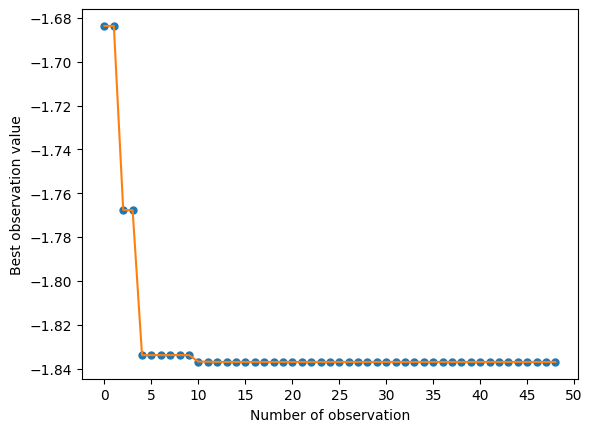

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
ll = [-1 * x for x in mm]
data = ll
fig, ax = plt.subplots()
tick = np.linspace(0,50,11)
# Plot the data as points
ax.plot(range(len(data)), data, '.', markersize=10, label='Data Points')

ax.plot(range(len(data)), data, '-', markersize=5, label='Data Line')

# Set x-axis and y-axis labels
ax.set_xlabel('Number of observation')
ax.set_ylabel('Best observation value')
plt.xticks(tick)
# Show the plot
plt.show()